In [1]:
#!/usr/bin/env python
%matplotlib inline
import logging
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import pickle
import random
import math
import itertools
from keras.layers import GlobalAveragePooling2D,Flatten
from keras.layers import Dense,Input,Lambda,concatenate,BatchNormalization,Dropout,Activation
from keras.models import Sequential, Model
from keras.optimizers import SGD,Adam
from sklearn.decomposition import PCA,IncrementalPCA
from sklearn.neighbors import KNeighborsClassifier
from keras.callbacks import EarlyStopping,Callback,TensorBoard,LearningRateScheduler
from keras import backend as K
from keras.initializers import TruncatedNormal
from keras.regularizers import l2,l1,l1_l2
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score,accuracy_score
import tensorflow as tf
import bob.measure


/Users/gltest/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

In [3]:
batch_num =  128
embedding_num  = 32
alpha = 0.2

In [4]:
def triplet_loss(y_true, y_pred):
    """
    :param y_true:
    :param y_pred:
    :return: triplet loss
    """
    # L= ||anchor_embedding - positive_embedding||  + alpha - ||anchor_embedding - negative_embedding||

    anchor, pos, neg = y_pred[:,0:embedding_num],y_pred[:,embedding_num:2*embedding_num],y_pred[:,2*embedding_num:3*embedding_num]
    dist_pos = K.sum(K.square(anchor - pos), axis=-1)
    dist_neg = K.sum(K.square(anchor - neg), axis=-1)
    margin = K.constant(alpha)
    return K.mean(K.sum((K.maximum(0.0,dist_pos-dist_neg+margin) )))


def accuracy(y_true, y_pred):
    """
    :param y_true:
    :param y_pred:
    :return: percentage of triplets satisfying  ||anchor_embedding - positive_embedding|| + alpha<||anchor_embedding - negative_embedding||
    """
    anchor, pos, neg = y_pred[:, 0:embedding_num], y_pred[:, embedding_num:2 * embedding_num], y_pred[:,2 * embedding_num:3 * embedding_num]
    dist_pos = K.sum(K.square(anchor - pos), axis=1)
    dist_neg = K.sum(K.square(anchor - neg), axis=1)
    margin = K.constant(alpha)
    return K.sum(K.cast(K.less(dist_pos+ margin ,dist_neg),dtype='int32'))/K.shape(y_pred)[0]

def l2_distance (anchor, query):
    """
    l2 distance between anchor and query embeddings
    :param anchor:
    :param query:
    :return:
    """
    return np.sum(np.square(anchor - query),axis=1)

def l2_similarity(query_embedding,label_embedings):
    """

    :param query_embedding:
    :param labels_embedings:
    :return:  l2 similarity and idics array of the closet identities label_embbedings toward query's embeddings
    """
    dist = np.zeros(len(label_embedings))
    dist = l2_distance(query_embedding, label_embedings)
    sorted_idcs = sorted(range(len(dist)), key=lambda k: dist[k])
    similarity = dist[sorted_idcs]
    return similarity, np.array(sorted_idcs)


In [5]:
def query_top_match(query_embedding,anchor_embedings,anchor_labels, thres, top_k=5):
    """return top match at threshold
    :param query_embedding:
    :param labels_embedings:
    :param anchor_labels:
    :paran anchor_thres;:
    :param top_num: top k matches
    :return: matching labels top_k matches at threshold
    """
    dist, idcs = l2_similarity(query_embedding,anchor_embedings)

    dist_top_k_idcs = np.where(dist < thres)[0][0:top_k]

    if np.asarray(dist_top_k_idcs).size >0:
        dist_top_k_labels = anchor_labels[idcs[dist_top_k_idcs]]
        unique_labels,first_idcs, counts = np.unique(dist_top_k_labels, return_counts=True,return_index=True)
        match_idx = np.where(counts==counts.max())

        if np.asarray(match_idx).size >=2:  # tied match
            # the first occuring one in the top_k
            match_idx = np.argsort(first_idcs[match_idx])
            match = unique_labels[match_idx[0]]
        else:
            match = unique_labels[match_idx]
        match = np.asscalar(match)  # convert 1x1 array to a numbers
        return match
    else:
        return []

In [6]:
def generate_anchor_positive(ids,batch_num=128):
    """
    :param ids: index array of the same identity
    :return: all pairs of [anchor, positive]. position matters
    """
    if len(ids) < 2 :
        #print("number of picture less than 2")
        return []
    results = []
    datasets = set()
    datasets.add(ids[0])
    datasets.add(ids[1])
    results.append(np.array([ids[0], ids[1]]))
    results.append(np.array([ids[1], ids[0]]))
    for idx in range(2, len(ids)):
        for elem in datasets:
            results.append(np.array([ids[idx], elem]))
            results.append(np.array([elem, ids[idx]]))
        datasets.add(ids[idx])
    results = np.array(results)
    if batch_num != None:
        if len(results) < batch_num:
            #copy itself to fill to the batch_num
            list = np.random.choice(len(results), batch_num-len(results))
            results = np.vstack( (results, results[list]))
        else:
            list = np.random.choice(len(results),batch_num)
            results = results[list]
    return results

def get_unique_labels(labels):
    """

    :param labels: unique labels preserving orders from the label array
    :return:
    """
    _, idx = np.unique(labels, axis=0, return_index=True)
    return labels[np.sort(idx)]


In [7]:
class EmbeddingUpdator(Callback):
    "Keras Callback implemenation of saving the model and update embeddings"
    def __init__(self, filepath,  train_codes, train_labels, data_dir, monitor='val_loss',verbose=0,
                 save_best_only=False, save_weights_only=False,
                 mode='auto', period=1 ):
        super(EmbeddingUpdator, self).__init__()
        self.monitor = monitor
        self.verbose = verbose
        self.filepath = filepath
        self.save_best_only = save_best_only
        self.save_weights_only = save_weights_only
        self.period = period
        self.epochs_since_last_save = 0
        self.train_codes = train_codes
        self.train_labels = train_labels
        self.data_dir = data_dir

        if mode not in ['auto', 'min', 'max']:
            logger.warn('ModelCheckpoint mode %s is unknown, '
                          'fallback to auto mode.' % (mode),
                          RuntimeWarning)
            mode = 'auto'

        if mode == 'min':
            self.monitor_op = np.less
            self.best = np.Inf
        elif mode == 'max':
            self.monitor_op = np.greater
            self.best = -np.Inf
        else:
            if 'acc' in self.monitor or self.monitor.startswith('fmeasure'):
                self.monitor_op = np.greater
                self.best = -np.Inf
            else:
                self.monitor_op = np.less
                self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epochs_since_last_save += 1
        if self.epochs_since_last_save >= self.period:
            self.epochs_since_last_save = 0
            filepath = self.filepath.format(epoch=epoch, **logs)
            if self.save_best_only:
                current = logs.get(self.monitor)
                if current is None:
                    logger.warn('Can save best model only with %s available, '
                                  'skipping.' % (self.monitor), RuntimeWarning)
                else:
                    if self.monitor_op(current, self.best):
                        if self.verbose > 0:
                            print('Epoch %05d: %s improved from %0.5f to %0.5f,'
                                  ' saving model to %s'
                                  % (epoch, self.monitor, self.best,
                                     current, filepath))
                        self.best = current
                        if self.save_weights_only:
                            self.model.save_weights(filepath, overwrite=True)
                        else:
                            self.model.save(filepath, overwrite=True)

                        # update the embedding
                        output = self.model.predict([self.train_codes,self.train_codes,self.train_codes],batch_size = 128)
                        embeddings = output[:,0:embedding_num]

                        file_name = os.path.join(self.data_dir, 'embeddings.npy')
                        np.save(open(file_name, 'wb'),embeddings)
                        # for i in range(len(embeddings)):
                        #     print(embeddings[i])
                        print("Embeddings updated")

                    else:
                        if self.verbose > 0:
                            print('Epoch %05d: %s did not improve' %
                                  (epoch, self.monitor))
            else:
                if self.verbose > 0:
                    print('Epoch %05d: saving model to %s' % (epoch, filepath))
                if self.save_weights_only:
                    self.model.save_weights(filepath, overwrite=True)
                else:
                    self.model.save(filepath, overwrite=True)


In [8]:
class tripletDataGenerator(object):
    "data generator for keras"
    def __init__(self,batch_size, classifier_filename,data_dir, shuffle = False):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.classifier_filename = classifier_filename
        self.data_dir = data_dir
        self.num_N = 32
        self.num_P = 32

    def generate(self, train_codes, train_labels,embedding_layer):
        "generate batch of sample"
        x_codes = train_codes
        labels = train_labels
        while True:
            file_name = os.path.join(self.data_dir, 'embeddings.npy')
            embeddings = np.load(file_name)

            print("embeddings loaded")
            if embeddings is None or len(embeddings)< 1:
                print("embeddings empty!")
                continue
            elif np.all(embeddings==0):
                print("embeddings collaps!")


            if self.shuffle == True:
                indics = np.arange(len(train_labels))
                np.random.shuffle(indics)
                x_codes = train_codes[indics]

                labels = train_labels[indics]
                embeddings = embeddings[indics]

            yield_idx = 0
            batch_num = self.batch_size

            step = 0
            while (step < len(labels)//self.batch_size):

                batch_idics = np.arange(batch_num*step,batch_num*(step+1))
                batch_codes = x_codes[batch_idics]
                batch_labels = labels[batch_idics]
                batch_embeddings = embeddings[batch_idics]
                #print("unique label length:", len(np.unique(batch_labels)))
                triplets = []
                for y in np.unique(batch_labels):
                    pos_ids = np.asarray(np.where((batch_labels == y)))[0]
                    if len(pos_ids) < 2:
                        continue
                    pos_P_idcs =  np.random.choice(len(pos_ids),  min(len(pos_ids),self.num_P))
                    pos_ids = pos_ids[pos_P_idcs]    
                    all_pos_embeddings = batch_embeddings[pos_ids] 
                    ng_idcs, =np.where((batch_labels!=y))
                    if len(ng_idcs) < 1:
                        continue
                    #sample at the most num_N
                    pos_N_idcs =  np.random.choice(len(ng_idcs),  min(len(ng_idcs),self.num_N))
                    ng_idcs = ng_idcs[pos_N_idcs]
                    all_ng_embeddings = batch_embeddings[ng_idcs]
                    # sorted_dist_neg, sorted_neg_idx = l2_similarity(batch_embeddings[pos_ids[0]], all_ng_embeddings)
                    #triplets = []
                    for a in range(len(pos_ids)):
                        sorted_dist_pos, sorted_pos_idx = l2_similarity(batch_embeddings[pos_ids[a]], all_pos_embeddings)
                        #the hardest <anchor, positive> and the hardest <anchor, negative>
                        if sorted_dist_pos[-1] > 0 :
                            max_pos_idx = pos_ids[sorted_pos_idx[-1]]
                        else:
                            continue  
                        sorted_dist_neg, sorted_neg_idx = l2_similarity(batch_embeddings[pos_ids[a]], all_ng_embeddings)
                        min_neg_idx = ng_idcs[sorted_neg_idx[0]]
                        triplets.append(np.array([pos_ids[a]+batch_num*step , max_pos_idx + batch_num*step, min_neg_idx+batch_num*step]))

                if len(triplets) > 0:
                    # randomize
                    triplets = np.array(triplets)
                    indics = np.arange(len(triplets))
                    np.random.shuffle(indics)
                    triplets = triplets[indics]
                    #print("length of triplets:", len(triplets))
                    yield [x_codes[triplets[:, 0]], x_codes[triplets[:, 1]], x_codes[triplets[:, 2]]], np.ones(len(triplets))
                step +=1


            # the last batch incomplete
            if len(labels) -batch_num*step> 0:
                triplets = []
                batch_idics = np.arange(batch_num*step,len(labels))
                batch_codes = x_codes[batch_idics]
                batch_labels = labels[batch_idics]
                batch_embeddings = embeddings[batch_idics]
                #print("unique label length:", len(np.unique(batch_labels)))
                for y in np.unique(batch_labels):
                    #triplets = []
                    pos_ids = np.asarray(np.where((batch_labels == y)))[0]
                    if len(pos_ids) < 2:
                        continue
                    pos_P_idcs =  np.random.choice(len(pos_ids),  min(len(pos_ids),self.num_P))
                    pos_ids = pos_ids[pos_P_idcs]  
                    all_pos_embeddings = batch_embeddings[pos_ids]
                    ng_idcs, =np.where((batch_labels!=y))
                    if len(ng_idcs) < 1:
                        continue
                    #sample at the most num_N
                    pos_N_idcs =  np.random.choice(len(ng_idcs),  min(len(ng_idcs),self.num_N))
                    ng_idcs = ng_idcs[pos_N_idcs]
                    all_ng_embeddings = batch_embeddings[ng_idcs]
                    # sorted_dist_neg, sorted_neg_idx = l2_similarity(batch_embeddings[pos_ids[0]], all_ng_embeddings)

                    for a in range(len(pos_ids)):
                        sorted_dist_pos, sorted_pos_idx = l2_similarity(batch_embeddings[pos_ids[a]], all_pos_embeddings)
                        #the hardest <anchor, positive> and the hardest <anchor, negative>
                        if sorted_dist_pos[-1] > 0 :
                            max_pos_idx = pos_ids[sorted_pos_idx[-1]]
                        else:
                            continue  
                        sorted_dist_neg, sorted_neg_idx = l2_similarity(batch_embeddings[pos_ids[a]], all_ng_embeddings)
                        min_neg_idx = ng_idcs[sorted_neg_idx[0]]
                        triplets.append(np.array([pos_ids[a]+batch_num*step , max_pos_idx + batch_num*step, min_neg_idx+batch_num*step]))

                if len(triplets) > 0:
                    # randomize
                    triplets = np.array(triplets)
                    indics = np.arange(len(triplets))
                    np.random.shuffle(indics)
                    triplets = triplets[indics]
                    yield [x_codes[triplets[:, 0]], x_codes[triplets[:, 1]], x_codes[triplets[:, 2]]], np.ones(len(triplets))

In [9]:
class tripletValidationDataGenerator(object):
    "data generator for keras"
    def __init__(self,batch_size, shuffle = False):
        self.batch_size = batch_size
        self.shuffle = shuffle
    
    def generate(self, val_codes,val_labels):
        "generate batch of sample"
        #unique_labels = get_unique_labels(labels)
        codes = val_codes
        labels = val_labels

        while True:
            if self.shuffle == True:
                indics = np.arange(len(val_labels))
                np.random.shuffle(indics)
                codes = val_codes[indics]
                labels = val_labels[indics]
            #print("val_labels:",labels)
            step = 0
            while (step < len(labels)//self.batch_size):
                batch_idics = np.arange(self.batch_size*step,self.batch_size*(step+1))
                batch_codes = codes[batch_idics]
                batch_labels = labels[batch_idics]
                unique_batch_labels = get_unique_labels(batch_labels)
                for y in unique_batch_labels:                
                    pos_ids = np.asarray(np.where((batch_labels == y)))[0]
                    if len(pos_ids) < 2:
                        continue
                    ng_idcs, =np.where((batch_labels!=y))
                    if len(ng_idcs) < 1:
                        continue    

                    ap_pair = generate_anchor_positive(pos_ids, batch_num=len(ng_idcs))
                    yield [batch_codes[ap_pair[:, 0]], batch_codes[ap_pair[:, 1]], batch_codes[ng_idcs]], np.ones(len(ap_pair))
                step +=1

            # the last batch incomplete

            if len(labels) - self.batch_size*step> 0:
                batch_idics = np.arange(self.batch_size*step,len(labels))
                batch_codes = codes[batch_idics]
                batch_labels = labels[batch_idics]
                unique_batch_labels = get_unique_labels(batch_labels)
                for y in unique_batch_labels:
                    pos_ids = np.asarray(np.where((batch_labels == y)))[0]
                    #print("y: ",y, pos_ids)
                    if len(pos_ids) < 2:
                        continue
                    ng_idcs, =np.where((batch_labels!=y))
                    if len(ng_idcs) < 1:
                        continue    

                    ap_pair = generate_anchor_positive(pos_ids, batch_num=len(ng_idcs) )
                    yield [batch_codes[ap_pair[:, 0]], batch_codes[ap_pair[:, 1]], batch_codes[ng_idcs]], np.ones(len(ap_pair))     
                

In [21]:
class TripletClassifier():
    def __init__(self, classfier_filename, data_dir, num_embeddings):
        self.classifier_filename = classfier_filename
        self.num_embeddings = num_embeddings
        self.alpha = 0.2
        self.thres = 1.0
        self.data_dir = data_dir
        K.set_image_data_format('channels_last')


    def prepare(self):
        self.train_codes = np.load(os.path.join(self.data_dir, 'train_codes.npy'))
        self.test_codes = np.load(os.path.join(self.data_dir, 'test_codes.npy'))
        self.train_labels = np.squeeze(np.load(os.path.join(self.data_dir, 'train_labels.npy')))
        self.test_labels = np.squeeze(np.load(os.path.join(self.data_dir, 'test_labels.npy')))
        self.test_idcs = np.load(os.path.join(self.data_dir,'test_labels_idcs.npy'))
        self.random_draw_codes = np.load(os.path.join(self.data_dir, 'random_draw_codes.npy'))
        self.random_draw_label = np.squeeze(np.load(os.path.join(self.data_dir, 'random_draw_labels.npy')))

        ss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
        train_idcs, val_idcs = next(ss.split(self.train_codes, self.train_labels))
        self.x_codes = self.train_codes[train_idcs]
        self.y_labels = self.train_labels[train_idcs]
        self.val_codes = self.train_codes[val_idcs]
        self.val_labels = self.train_labels[val_idcs]


        # classifier
        logger.info("train codes shape {}".format(self.x_codes.shape))
        logger.info("validation codes shape {}".format(self.val_codes.shape))
        logger.info("train label shape {}".format(self.y_labels.shape))
        logger.info("validation label shape {}".format(self.val_labels.shape))
        logger.info("test codes  shape {}".format(self.test_codes.shape))
        logger.info("test labels  shape {}".format(self.test_labels.shape))

        input = Input(shape=(1, 1, 2048))
        x = Flatten(name='flatten')(input)
        x = Dense(self.num_embeddings, kernel_initializer= TruncatedNormal(stddev=0.05),
                 use_bias= False, name='embeddings', kernel_regularizer=l2(0.001))(x)
        x = Lambda(lambda  x: K.l2_normalize(x,axis=1))(x)

        branch = Model(inputs=input,outputs=x)

        anchors = Input(shape=(1, 1, 2048))
        positives = Input(shape=(1, 1, 2048))
        negatives = Input(shape=(1, 1, 2048))

        anchors_embeddings = branch(anchors)
        positives_embeddings = branch(positives)
        negatives_embeddings = branch(negatives)
        merged = concatenate([anchors_embeddings, positives_embeddings,negatives_embeddings],axis=1)

        self.model = Model([anchors, positives,negatives], merged)
        self.model.compile(loss= triplet_loss,
                           optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
                            metrics=[accuracy])
        self.model.summary()

    def train(self):

        ## split training set further for training and validation set

        start_time = time.time()
        # initial embedding. The average of all training data.
        pca = PCA(n_components=embedding_num)
        temp = np.array(self.x_codes).reshape((self.x_codes.shape[0],-1))
        g_embeddings = pca.fit_transform(temp)

        file_name = os.path.join(self.data_dir, 'embeddings.npy')
        np.save(open(file_name, 'wb'),g_embeddings)
        print("Embeddings updated")

        logger.info('Training starts...' )
        checkpointer = EmbeddingUpdator(filepath=self.classifier_filename,train_codes=self.x_codes, train_labels = self.y_labels , data_dir = self.data_dir,
                monitor ='val_loss', verbose=1, save_best_only=True)
        #early_stopping = EarlyStopping(monitor='val_loss',patience=20)
        tbCallBack = TensorBoard(log_dir='./logs',batch_size= batch_num, histogram_freq=0, write_graph=True,
                                                 write_images=True, write_grads = True)
        tbCallBack.set_model(self.model)

        train_data_params = {
            'batch_size':batch_num,
            'shuffle':True,
            'classifier_filename': self.classifier_filename,
            'data_dir':self.data_dir
        }
        val_batch_size = 64
        val_data_params = {
            'batch_size':val_batch_size,
            'shuffle':True
        }
        train_data_generator = tripletDataGenerator(**train_data_params).generate(self.x_codes,self.y_labels,self.model)
        val_data_generator = tripletValidationDataGenerator (**val_data_params).generate(self.val_codes,self.val_labels)

        evaluation = self.model.fit_generator(train_data_generator,
                        steps_per_epoch=(len(self.y_labels)+ batch_num-1) // batch_num,
                        epochs=1000,
                        verbose=1,
                        callbacks=[checkpointer,tbCallBack],
                        validation_data=val_data_generator,
                        validation_steps = (val_batch_size * len(np.unique(self.val_labels))+ batch_num-1)//batch_num,
                        use_multiprocessing = False)

        logger.info('Completed in {} seconds'.format(time.time() - start_time))
        logger.info("Training result {}".format(evaluation))
        pickle.dump(evaluation.history, open("../model/triplet_train_history.pickle", "wb"))

        return 0

    def train_history_visual(self):

        # summarize history for accuracy
        with open("../model/triplet_train_history.pickle", 'rb') as pickle_file:
            history = pickle.load(pickle_file)
        plt.figure(figsize=(8,4))

        plt.subplot(1, 2, 1)
        plt.plot(history['accuracy'])
        plt.plot(history['val_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='lower right')
        axes = plt.gca()
        axes.set_ylim([0.0, 1.05])

        plt.subplot(1, 2, 2)
        plt.plot(history['loss'])
        plt.plot(history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper right')

        plt.show()

    def predict(self, test_codes, anchor_embeddings,anchor_labels, anchor_thres,top_k = 5):
        test_embeddings = self.model.predict([test_codes,test_codes,test_codes],batch_size = 128)
        test_embeddings = test_embeddings[:,0:embedding_num]
        match_labels_thres = []

        for query_embedding in test_embeddings:
            dist = l2_distance(query_embedding[None, :], anchor_embeddings)
            sorted_idcs = np.array(sorted(range(len(dist)), key=lambda k: dist[k]))
            top_k_idcs = sorted_idcs[:top_k]
            top_k_match = []
            for cand in top_k_idcs:
                if dist[cand] < anchor_thres[cand]:
                    top_k_match.append(anchor_labels[cand])
            if len(top_k_match )>0:
                unique_labels,first_idcs, counts = np.unique(np.array(top_k_match), return_counts=True,return_index=True)
                if len(unique_labels) >0 :
                    match_idx = np.where(counts==counts.max())
                    if  np.asarray(match_idx).size >=2:  #tied match
                        # the first occuring one in the top_k . It has the smallest distance
                        match_idx = np.argsort(first_idcs[match_idx])
                        match = unique_labels[match_idx[0]]
                        match = np.ravel(match)
                    else:
                        match = unique_labels[match_idx]
                    match_labels_thres.append(np.asscalar(match))
            else:
                match_labels_thres.append(-1)

        return match_labels_thres

    def generate_labels_embeddings_threshold(self):
        self.model.load_weights(self.classifier_filename)
        embeddings = self.model.predict([self.val_codes, self.val_codes, self.val_codes],batch_size = 128)
        y_labels = self.val_labels
        embeddings = embeddings[:,0:embedding_num]
        label_embeddings = []
        label_thres = []
        labels = []
        num_N = 128
        for id in np.unique(y_labels):
            same_labels_ids = np.where(y_labels == id )[0]
            ng_labels_ids = np.where(y_labels !=id )[0]
            pos_dist = []
            neg_dist = []
            label_embeddings.append(embeddings[same_labels_ids].mean(axis=0))

            for i,j in itertools.combinations(same_labels_ids,2):
                pos_dist.append(l2_distance(embeddings[i][None,:], embeddings[j][None,:]))

            for i in same_labels_ids:
                for j in ng_labels_ids:
                    neg_dist.append(l2_distance(embeddings[i][None,:], embeddings[j][None,:]))
            pos_dist = np.array(pos_dist,dtype='double').ravel()
            neg_dist = np.array(neg_dist,dtype='double').ravel()
            label_thres.append(neg_dist.min())
            labels.append(id)
        label_embeddings = np.vstack(label_embeddings)

        return label_embeddings,labels,np.array(label_thres)

    def evaluate(self):
        true_accept = 0.0
        false_accept = 0.0
        true_reject = 0.0
        false_reject = 0.0

        anchor_embeddings, anchor_labels, anchor_thres = self.generate_labels_embeddings_threshold()
        logger.info("Distance threshold {0:.4f}:".format(np.mean(anchor_thres)) )

        logger.info("Testing all authorized labels...")
        predictions_thres = self.predict(self.test_codes,anchor_embeddings,anchor_labels, anchor_thres,top_k=5)

        all_test = 0.0

        for test_id in range(len(self.test_labels)):
            if np.asarray(np.where(predictions_thres[test_id] == self.test_labels[test_id])).size==0:
                logger.info("data id  {} false rejected as label {}, true label {}"
                            .format(self.test_idcs[test_id],predictions_thres[test_id],self.test_labels[test_id]))
                false_reject += 1.0

            else:
                true_accept += 1.0
            all_test += 1.0

        TR = true_accept/all_test
        FR = false_reject/all_test

        logger.info("true_acceptance: {0:.4f}".format(TR))
        logger.info("false_rejection: {0:.4f}".format(FR))

        logger.info("Testing random draw labels...")

        predictions_thres = self.predict(self.random_draw_codes,anchor_embeddings,anchor_labels, anchor_thres,top_k=5)
        # what went wrong
        true_accept = 0.0
        false_accept = 0.0
        true_reject = 0.0
        false_reject = 0.0
        all_test = 0.0
        for test_id in range(len(self.random_draw_codes)):
            all_test += 1 
            if (self.random_draw_label[test_id]== self.train_labels).any() == True:
                # in the system
                if np.asarray(predictions_thres[test_id]).size == 0 or predictions_thres[test_id] != self.random_draw_label[test_id]:
                    false_reject += 1.0
                    logger.info("data id  {} false rejected as label {}, true label {}"
                                .format(test_id, predictions_thres[test_id], self.random_draw_label[test_id]))
                else:
                    true_accept += 1.0
                    logger.info("data id  {} accepted label  {} true label {} "
                                .format(test_id, predictions_thres[test_id],self.random_draw_label[test_id] ))
            else:
                # not in the system
                if predictions_thres[test_id]!= -1:
                    false_accept += 1.0
                    logger.info("data id  {} false accepted as label {}, none autherized label {}"
                                .format(test_id, predictions_thres[test_id], self.random_draw_label[test_id]))

                else:
                    true_reject += 1.0
                    logger.info("data id  {} rejected label {}, none autherized"
                                .format(test_id, self.random_draw_label[test_id]))


        FAR = false_accept / all_test
        TR = true_reject/all_test
        logger.info("true_rejection: {0:.4f}".format(TR))
        logger.info("false_acceptance: {0:.4f}".format(FAR))

    def Alejandro_Toledo_match_visual(self):
        # its label is 128
        Alejandro_Toledo_idcs = np.where(self.test_labels == 128)[0]

        df = pd.read_csv(os.path.join(self.data_dir,"lfw_dataset.csv"),names=['id','label','name','path'])
        predicted_name = []
        predicted_image_path = []
        true_image_path = []
        
        anchor_embeddings, anchor_labels, anchor_thres = self.generate_labels_embeddings_threshold()
        
        for i in range(len(Alejandro_Toledo_idcs)):
            test_codes = self.test_codes[Alejandro_Toledo_idcs[i]]
            predicted_label = self.predict(test_codes[None,:],anchor_embeddings,anchor_labels, anchor_thres,top_k=5)[0]
            data_id = self.test_idcs[Alejandro_Toledo_idcs[i]]

            if predicted_label != 128 and  predicted_label != -1 :
                predicted_name.append(df[df['label']== str(predicted_label)]['name'].values[0])
                true_image_path.append(df.iloc[data_id]['path'].strip())
                predicted_image_path.append(df[df['label']== str(predicted_label)]['path'].values[0])

        fig = plt.figure(figsize=(8, 6))
        for i in range(len(predicted_image_path)):
            ax = fig.add_subplot(len(predicted_image_path),2, 2*i + 1, xticks=[], yticks=[])
            img = mpimg.imread(true_image_path[i].strip())
            ax.imshow(img)
            ax = fig.add_subplot(len(predicted_image_path),2, 2*i + 2, xticks=[], yticks=[])
            img = mpimg.imread(predicted_image_path[i].strip())
            ax.imshow(img)
            ax.set_title("predicted as {}".format(predicted_name[i]),
                color=("green" if predicted_name[i] == 'Alejandro_Toledo' else "red")) 
        plt.show()

    def GW_Bush_Distance_visual(self):
        # to see how close each picture's embedding is
        # its label is 1872
        GW_Bush_idcs = np.where(self.test_labels == 1872)[0]

        GW_Bush_embeddings = self.model.predict([self.test_codes[GW_Bush_idcs],self.test_codes[GW_Bush_idcs],self.test_codes[GW_Bush_idcs]],batch_size = 128)
        GW_Bush_embeddings = GW_Bush_embeddings[:,0:embedding_num]

        df = pd.read_csv(os.path.join(self.data_dir,"lfw_dataset.csv"),names=['id','label','name','path'],header = None)
        
        GW_Bush_anchor = GW_Bush_embeddings[0]
        dist = l2_distance(GW_Bush_anchor[None,:], GW_Bush_embeddings)

        fig = plt.figure(figsize=(15, 25))
        for i in range(len(GW_Bush_idcs)):
            data_id = self.test_idcs[GW_Bush_idcs[i]]
            ax = fig.add_subplot(len(GW_Bush_idcs),3, i + 1, xticks=[], yticks=[])
            img = mpimg.imread(df.iloc[data_id+1]['path'].strip())
            ax.imshow(img)
            ax.set_title(label = (" {0:.4f}".format(dist[i]) if i> 0 else "anchor"),color="green" ) 
        plt.show()


In [22]:
clr = TripletClassifier(classfier_filename='../model/weights_triplet_loss.hdf5',
                        data_dir='../data/cropped_20',num_embeddings = embedding_num)
clr.prepare()


INFO:__main__:train codes shape (1520, 1, 1, 2048)
INFO:__main__:validation codes shape (381, 1, 1, 2048)
INFO:__main__:train label shape (1520,)
INFO:__main__:validation label shape (381,)
INFO:__main__:test codes  shape (476, 1, 1, 2048)
INFO:__main__:test labels  shape (476,)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 1, 1, 2048)   0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           (None, 1, 1, 2048)   0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 1, 1, 2048)   0                                            
__________________________________________________________________________________________________
model_5 (Model)                 (None, 32)           65536       input_10[0][0]                   
                                                                 input_11[0][0]                   
          

In [12]:

clr.train()

INFO:__main__:Training starts...


Embeddings updated
Epoch 1/1000
embeddings loaded
 6/12 [==============>...............] - ETA: 0s - loss: 28.2332 - accuracy: 0.0088    embeddings loaded
Epoch 00000: val_loss improved from inf to 11.21869, saving model to ../model/weights_triplet_loss.hdf5
Embeddings updated
12/12 [==============================] - 0s 39ms/step - loss: 26.2614 - accuracy: 0.0044 - val_loss: 11.2187 - val_accuracy: 0.0437
Epoch 2/1000
 7/12 [================>.............] - ETA: 0s - loss: 24.7352 - accuracy: 0.0000e+00Epoch 00001: val_loss improved from 11.21869 to 9.95465, saving model to ../model/weights_triplet_loss.hdf5
Embeddings updated
12/12 [==============================] - 0s 24ms/step - loss: 23.4005 - accuracy: 0.0000e+00 - val_loss: 9.9547 - val_accuracy: 0.0147
Epoch 3/1000
12/12 [==============================] - 0s 18ms/step - loss: 24.4010 - accuracy: 0.0000e+00 - val_loss: 11.3870 - val_accuracy:

INFO:__main__:Completed in 295.3607850074768 seconds
INFO:__main__:Training result <keras.callbacks.History object at 0x127be1fd0>


0

INFO:__main__:Distance threshold 0.6626:
INFO:__main__:Testing all authorized labels...
INFO:__main__:data id  247 false rejected as label -1, true label 386
INFO:__main__:data id  1768 false rejected as label 4058, true label 3738
INFO:__main__:data id  2 false rejected as label -1, true label 128
INFO:__main__:data id  248 false rejected as label -1, true label 386
INFO:__main__:data id  554 false rejected as label -1, true label 1405
INFO:__main__:data id  2082 false rejected as label -1, true label 5040
INFO:__main__:data id  629 false rejected as label 1934, true label 1872
INFO:__main__:data id  1816 false rejected as label -1, true label 4058
INFO:__main__:data id  2175 false rejected as label -1, true label 5459
INFO:__main__:data id  282 false rejected as label 3128, true label 418
INFO:__main__:data id  1131 false rejected as label -1, true label 2469
INFO:__main__:data id  1055 false rejected as label -1, true label 2277
INFO:__main__:data id  669 false rejected as label 196

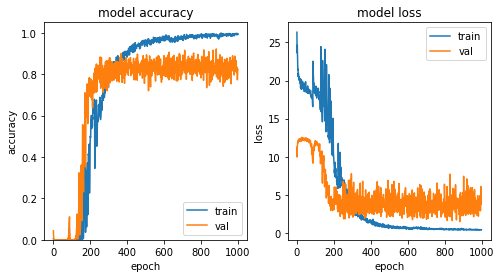

In [13]:
clr.evaluate()
clr.train_history_visual()

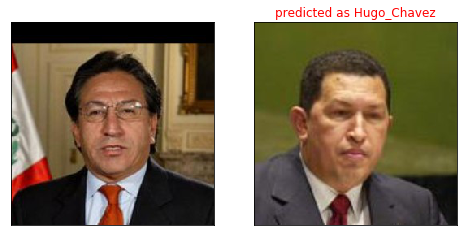

In [14]:
clr.Alejandro_Toledo_match_visual()

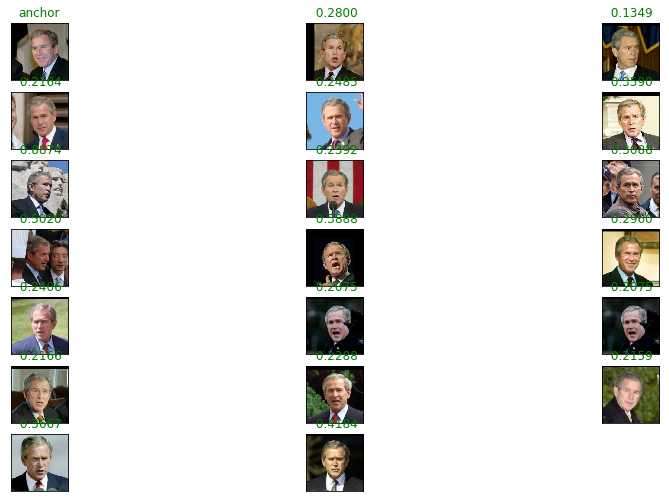

In [23]:
clr.GW_Bush_Distance_visual()

Actually all Bush picture embeddings are pretty close to its anchor pictures.But side pictures(0.8874,0.5020) have larger distance than frontal pictures. This suggests that even within the same identity(supposedly only one cluster,we might have mini clusters. This would disturbe nearest neighbor matching. 